### Notebook for the pseudotime inference on COPD - CTRL using `cellrank`'s new [tutorial](https://cellrank.readthedocs.io/en/latest/notebooks/tutorials/cellrank_meets_pseudotime.html).

- **Developed by**: carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230417

### Load required modules

In [1]:
import anndata
#import palantir
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr

from cellrank.kernels import CytoTRACEKernel

### Set up working environment

In [2]:
np.random.seed(1769)

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cellrank            1.5.1
cffi                1.15.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
defusedxml          0.7.1
docrep              0.3.2
executing           1.2.0
h5py                3.8.0
hypergeom_ufunc     NA
igraph              0.10.4
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.22.0
ipython_genutils    0.2.0
ipywidgets          7.6.5
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
matplotlib          3.7.1
mpl_toolkits        NA
natsort             8.3.1
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc       

### Read in dataset

In [3]:
adata = sc.read_h5ad('../../data/Healthy-IAV_Mixed_scVI-annotated_ctl230504.h5ad')
adata

AnnData object with n_obs × n_vars = 4104 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts

### Process data to the `CytoTRACE` kernel liking 

In [4]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

### Use scVelo's `moments` function for imputation 
- Note that hack we're using here: we're copying our `.X` matrix into the layers because that's where `scv.tl.moments` expects to find counts for imputation

In [5]:
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs = 50, n_neighbors = 50)

Normalized count data: X.
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Use the dynamical model from scVelo to estimate model parameters and compute velocities.

In [6]:
scv.tl.recover_dynamics(adata, n_jobs = 4, n_top_genes = 1786)
scv.tl.velocity(adata, mode = "dynamical")

recovering dynamics (using 4/6 cores)


/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/1786 [00:00<?, ?gene/s]

/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:05:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


### Set up the `VelocityKernel` from the adata object containing the scVelo-computed velocities and compute a cell-cell transition matrix.

In [7]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/4104 [00:00<?, ?cell/s]

/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/4104 [00:00<?, ?cell/s]

VelocityKernel[n=4104, model='deterministic', similarity='correlation', softmax_scale=1.502]

/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


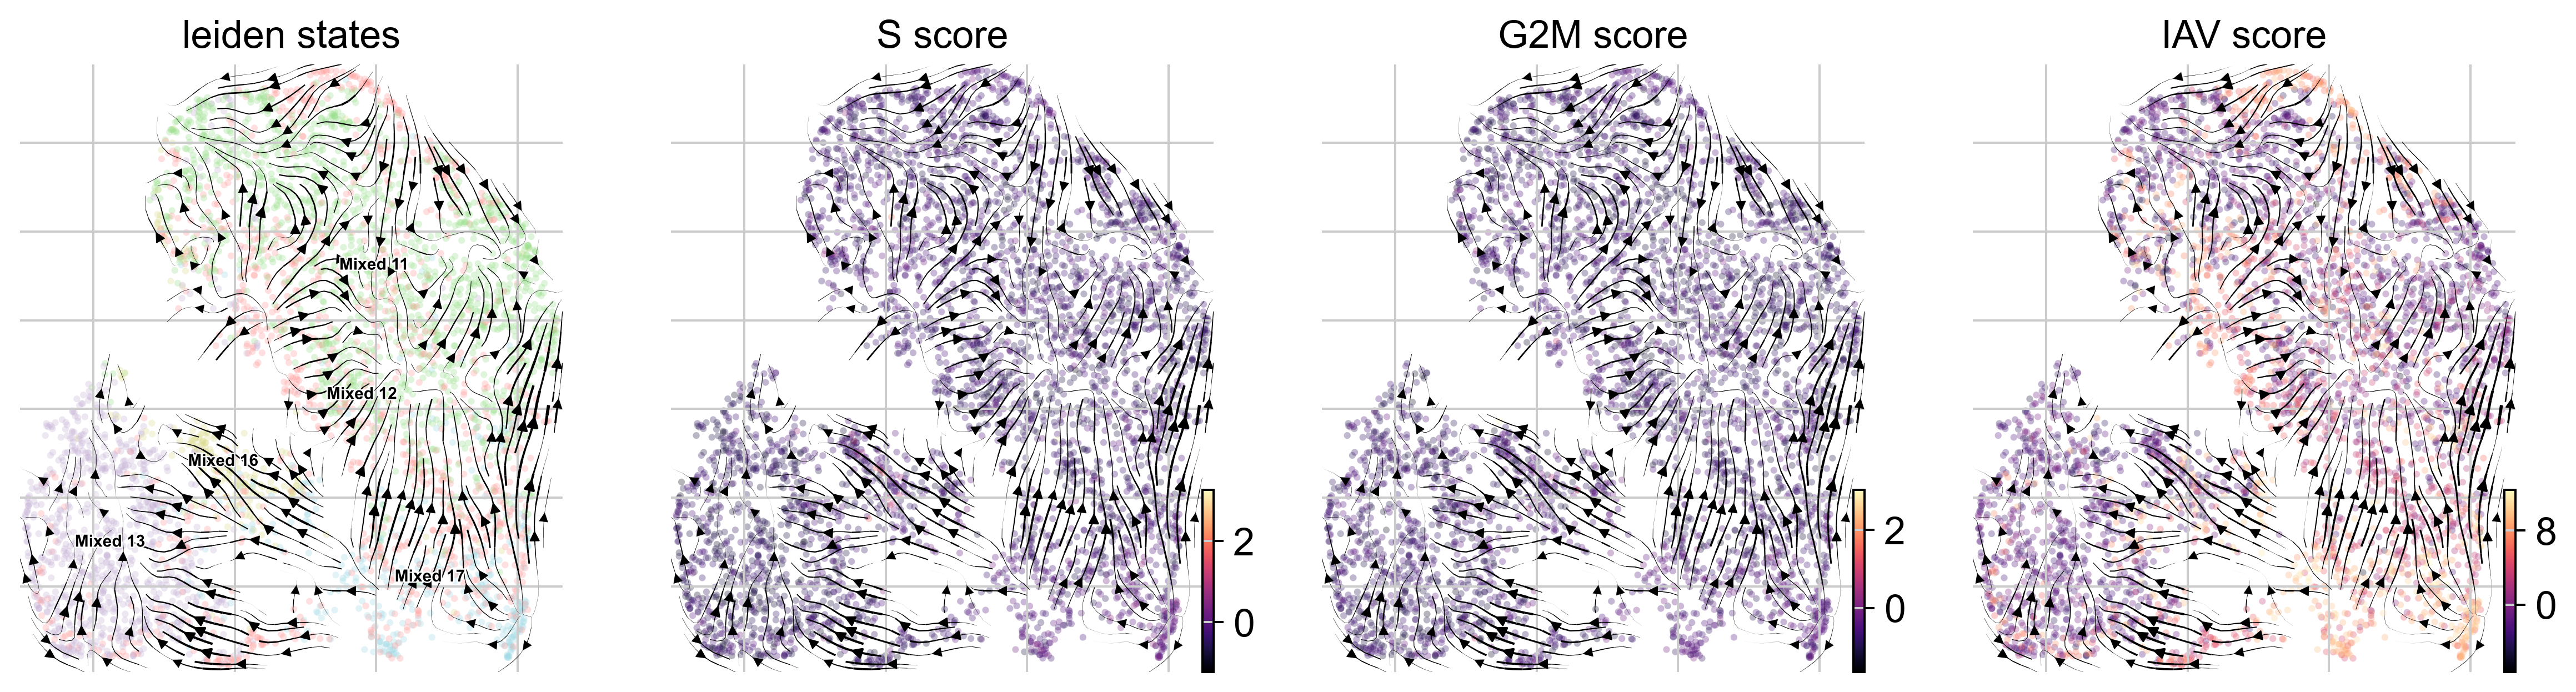

In [23]:
vk.plot_projection(basis = 'umap', color = ['leiden_states', 'S_score', 'G2M_score', 'IAV_score'], legend_fontsize = 6, size = 24, color_map = 'magma', arrow_size = 0.8, linewidth = 0.6)

In [9]:
adata

AnnData object with n_obs × n_vars = 4104 × 7000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_counts

In [10]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending = False).index
#top_genes = adata.var['velocity_genes'].sort_values(ascending = False).index
scv.pl.scatter(adata, basis = top_genes[:10], ncols = 5, frameon = False, color = ['leiden_states'])

### Choosing the right pseudotime

In [11]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.diffmap(adata, random_state = 1769, n_comps = 50)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing Diffusion Maps using n_comps=50(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9922966  0.9878197  0.9714853  0.95518637 0.9357767
     0.9144525  0.91188914 0.8901771  0.88806266 0.8671101  0.85445416
     0.85127705 0.83801514 0.8355511  0.83265245 0.82174534 0.8162285
     0.8109149  0.80983907 0.8003113  0.7942478  0.7934939  0.78816056
     0.78297716 0.77349436 0.7630408  0.75661105 0.7506653  0.746013
     0.7408085  0.7380644  0.734773   0.72661805 0.7262831  0.7221992
     0.7207682  0.7181922  0.71072406 0.70287794 0.700145   0.69864005
     0.696318   0.69552255 0.6903571  0.6889252  0.680284   0.6776465
     0.67400694 0.67173576]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_ev

In [12]:
adata.obsm['X_diffmap'][:, 3].argmax()

3275

/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


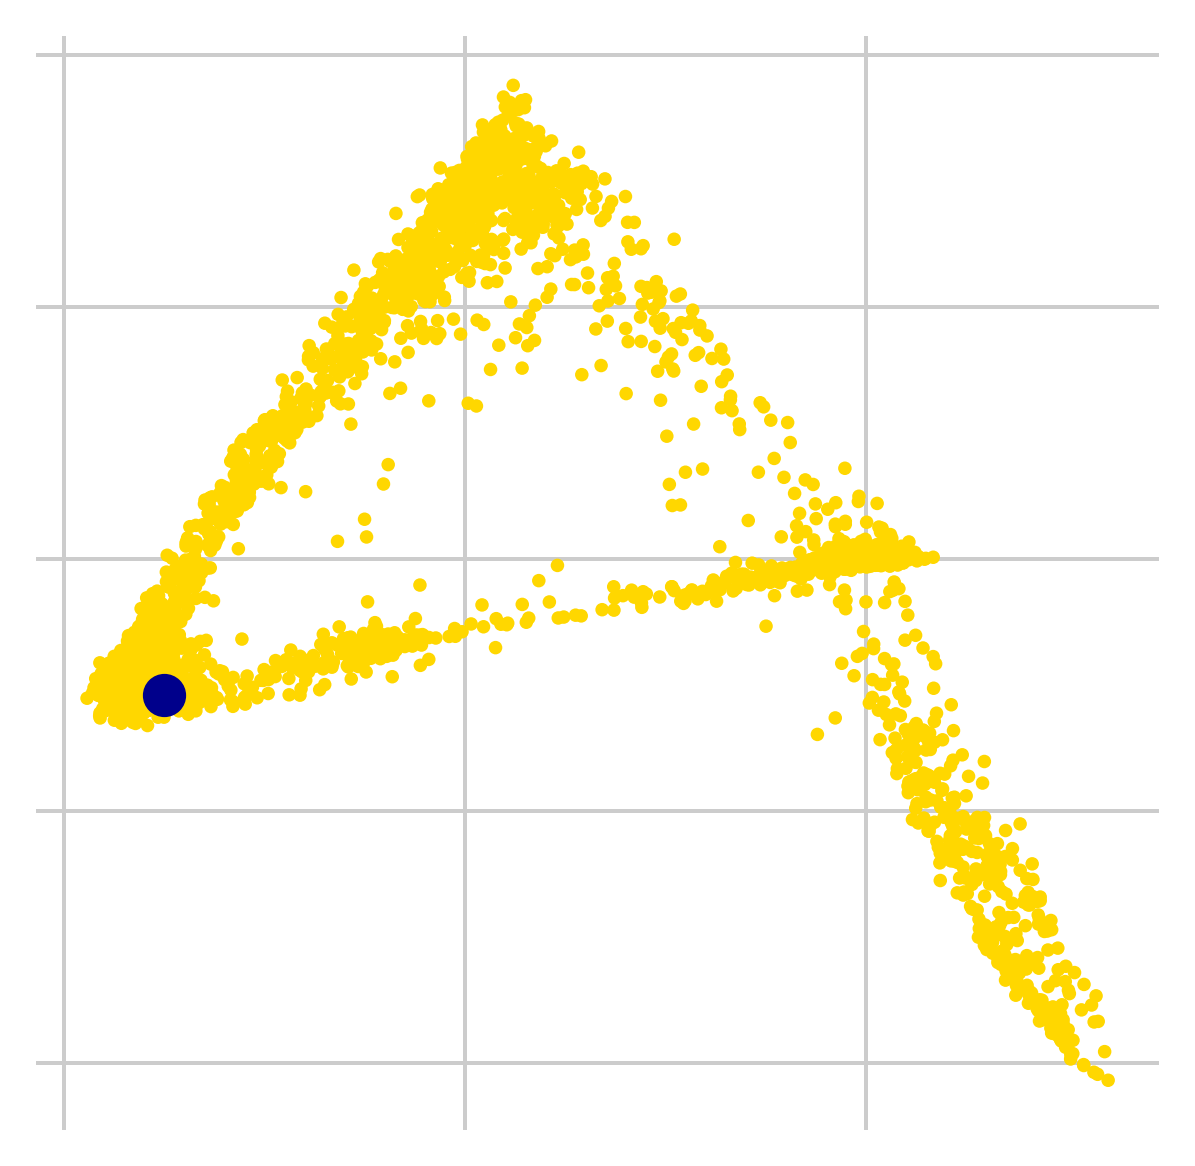

In [13]:
root_ixs = 1721 # has been found using `adata.obsm['X_diffmap'][:, 3].argmax()`
scv.pl.scatter(adata, basis = 'diffmap', c = [root_ixs], legend_loc = 'right', components = ['2, 3'])

adata.uns['iroot'] = root_ixs

In [22]:
sc.tl.dpt(adata)
scv.pl.scatter(adata, basis = 'umap', color = ['leiden_states', 'dpt_pseudotime', 'S_score', 'G2M_score', 'IAV_score'], color_map = 'magma', legend_loc = 'on data', legend_fontsize = 8, size = 6)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/cartalop/mambaforge/envs/cellrank/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


### Plot pseudotime trajectories

In [15]:
adata.obs['leiden_states'].cat.categories

Index(['Mixed_11', 'Mixed_12', 'Mixed_13', 'Mixed_16', 'Mixed_17'], dtype='object')

In [16]:
mixed_trajectory = ['Mixed_11', 'Mixed_12', 'Mixed_13', 'Mixed_16', 'Mixed_17']
goblet_trajectory = ['Goblet_0', 'Goblet_6', 'Goblet_7']

In [17]:
mask = np.in1d(adata.obs['leiden_states'], mixed_trajectory)
sc.pl.violin(adata[mask], keys=['dpt_pseudotime'], groupby = 'leiden_states', rotation = -90,
            order = mixed_trajectory)

In [18]:
mask = np.in1d(adata.obs['leiden_states'], goblet_trajectory)
sc.pl.violin(adata[mask], keys=['dpt_pseudotime'], groupby = 'leiden_states', rotation = -90,
            order = goblet_trajectory)

KeyError: 'Goblet_0'

### Running the `PseudotimeKernel`

In [ ]:
pk = cr.kernels.PseudotimeKernel(adata, time_key = 'dpt_pseudotime')
pk.compute_transition_matrix()

print(pk)

In [ ]:
pk.plot_projection(basis = 'umap', recompute = True, color = ['leiden_states', 'S_score', 'G2M_score', 'IAV_score'], legend_fontsize = 6, size = 8, color_map = 'magma', arrow_size = 0.7, linewidth = 0.5)

### Export object with temporal info and HVG

In [ ]:
adata